# MNIST

In this example, we'll demonstrate how to use [dataduit](https://github.com/JackBurdick/dataduit) to create tensorflow datasets from the readily available tfdataset by specifying a config file.

We'll then demonstrate how to use yeahml to create/build/evaluate a model on the created data.

#### Note:
> The model for this project likely doesn't make sense. I am not personally familiar with the dataset/problem, I was interested showing an example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import pandas as pd
import tensorflow as tf
import dataduit as dd
import yeahml as yml

## Create Datasets

In [3]:
# only use 2 of the features
dd_dict = {
    "meta": {
        "name": "mnist",
        "logging": {"log_stream_level": "INFO"},
        "in": {"from": "online", "type": "tfd"},
    },
    "read": {
        "split_percents": [75, 15, 10],
        "split_names": ["train", "val", "test"],
        "from_stage": "preprocessed"
    },
}

In [4]:
# create the datasets based on the above defined names/splits/specifed data
ds_dict_raw = dd.read(dd_dict)

root dir set to None


## alter dataset

In [5]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, tf.cast(image, tf.float32) / 255.0

In [6]:
for k, cur_ds in ds_dict_raw.items():
    
    cur_ds = cur_ds.map(
            normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )

    ds_dict_raw[k] = cur_ds

In [7]:
ds_dict = {"mnist": ds_dict_raw}

`ds_dict` is a dictionary containing the tensorflow datasets (as specified above). which can be accessed like this:

```python
ds_val = ds_dict["val"]
```

## Specify the Model

In [8]:
example = "./main_config.yml"
yml_dict = yml.create_configs(example)

## Build the model

In [9]:
# If you receive an error:
# AttributeError: 'google.protobuf.pyext._message.RepeatedCompositeCo' object has no attribute 'append'
# I personally used `pip install -U protobuf=3.8.0` to resolve
# per https://github.com/tensorflow/tensorflow/issues/33348
model = yml.build_model(yml_dict)

build_logger: INFO     -> START building graph
build_logger: INFO     information json file created


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x_image (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
conv_2_downsample (Conv2D)   (None, 14, 14, 16)        1168      
_________________________________________________________________
conv_3 (Conv2D)              (None, 14, 14, 16)        2320      
_________________________________________________________________
conv_4_downsample (Conv2D)   (None, 7, 7, 32)          4640      
_________________________________________________________________
conv_5_upsample (Conv2DTrans (None, 14, 14, 32)        9248      
_________________________________________________________________
conv_6_upsample (Conv2D)     (None, 14, 14, 16)        4624  

## Train the Model

Notice here that we're using the created training and validation sets from `ds_dict`

In [11]:
ds_dict

{'mnist': {'train': <ParallelMapDataset shapes: ((28, 28, 1), (28, 28, 1)), types: (tf.float32, tf.float32)>,
  'val': <ParallelMapDataset shapes: ((28, 28, 1), (28, 28, 1)), types: (tf.float32, tf.float32)>,
  'test': <ParallelMapDataset shapes: ((28, 28, 1), (28, 28, 1)), types: (tf.float32, tf.float32)>}}

In [12]:
%%time
train_dict = yml.train_model(model, yml_dict, ds_dict)

train_logger: INFO     START - training
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 1
train_logger: INFO     done validation - 45000
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 2
train_logger: INFO     done validation - 90000
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 3
train_logger: INFO     done validation - 135000
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 4
train_logger: INFO     done validation - 180000
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     main_opt removed from list of opt. remaining: []
train_logger: INFO     is_training: False
train_

CPU times: user 14min 6s, sys: 43.8 s, total: 14min 49s
Wall time: 5min 32s


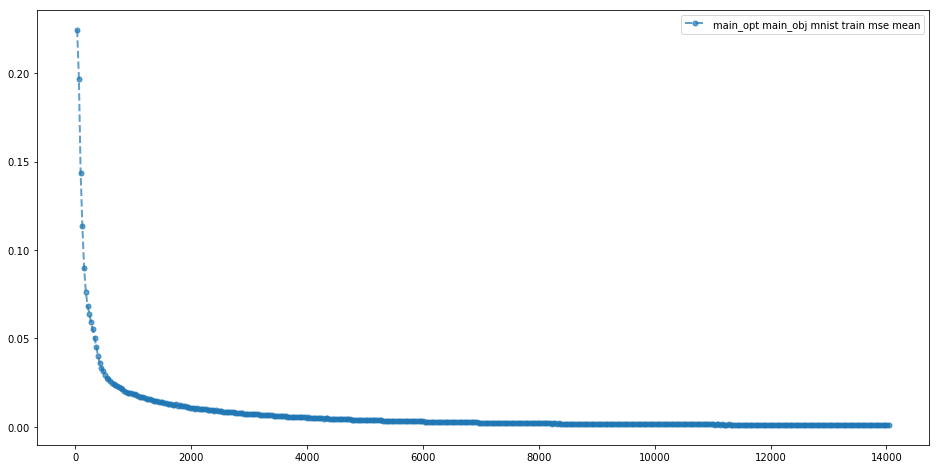

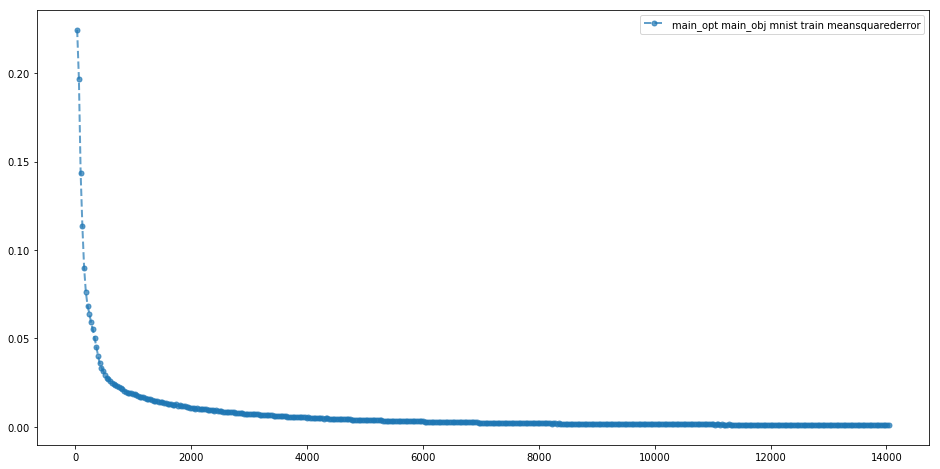

In [13]:
yml.basic_plot_tracker(
    train_dict["tracker"],
    metrics=True,
    local=False,
    training=True,
    validation=False,
    loss=True,
    size=(16, 8),
)

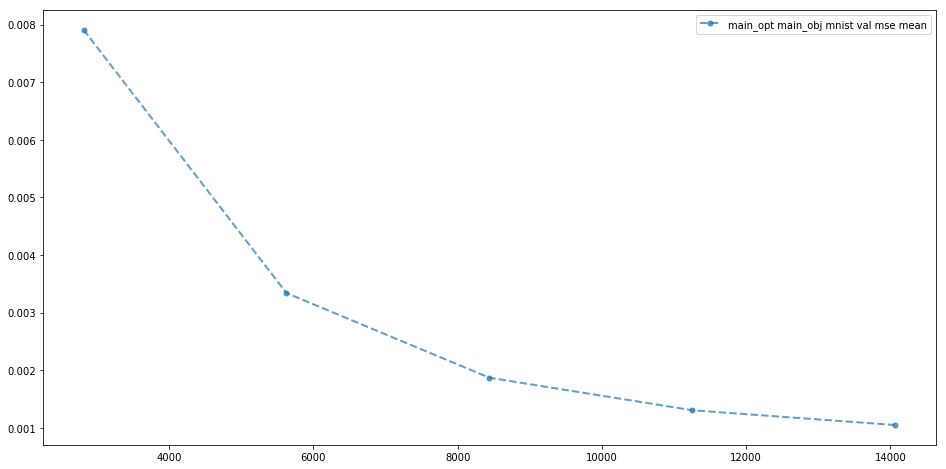

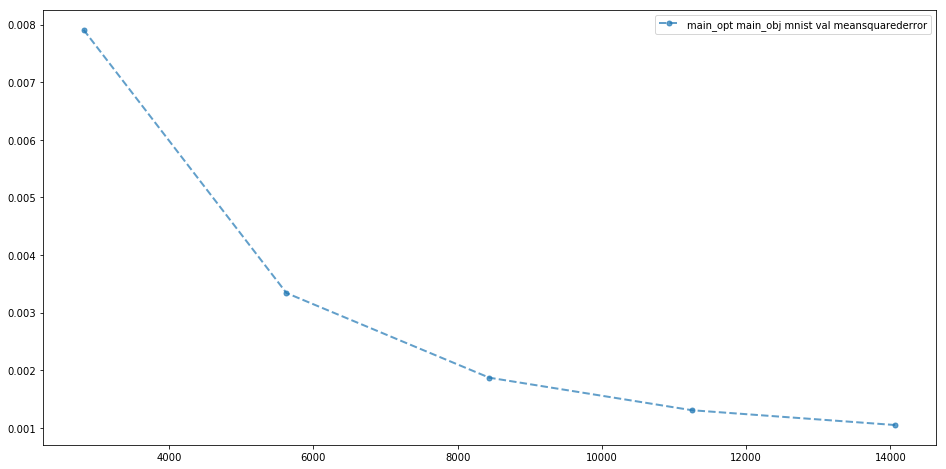

In [14]:
yml.basic_plot_tracker(
    train_dict["tracker"],
    metrics=True,
    local=False,
    training=False,
    validation=True,
    loss=True,
    size=(16, 8),
)

## Evaluate the Model

In [15]:
aa = ds_dict["mnist"]["train"].take(8)
#aa = tf.expand_dims(aa, 0)

In [16]:
from yeahml.train.setup.datasets import get_datasets

In [17]:
j_d = get_datasets(ds_dict, yml_dict["data"], yml_dict["hyper_parameters"])

In [18]:
j_d['mnist']['train']

<BatchDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.float32, tf.float32)>

In [19]:
for a in j_d['mnist']['train'].take(1):
    z = model(a)

In [20]:
from pathlib import Path

In [22]:
import matplotlib.pyplot as plt

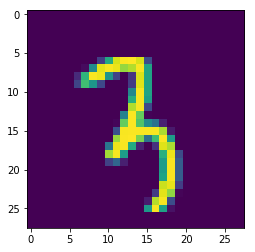

In [24]:
plt.imshow(tf.squeeze(a[0][0]))

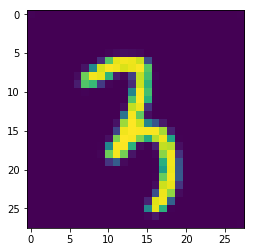

In [26]:
plt.imshow(tf.squeeze(z[0]))

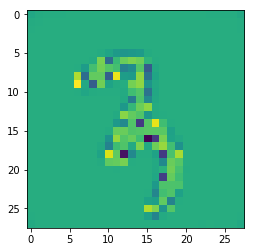

In [27]:
plt.imshow(tf.squeeze(a[0][0]) - tf.squeeze(z[0]))

In [15]:
# eval_dict = yml.eval_model(
#     model,
#     yml_dict,
#     dataset=ds_dict["test"]
# )
# print(eval_dict)

## Inspect model in Tensorflow

In the command line you can navigate to the `albalone` directory and run: (provided tensorboard is installed in your environment)

```bash
tensorboard --logdir model_a/
```